In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
import random

In [2]:
df_all = pd.read_csv(r"Data\people_wiki.csv", index_col = 0)

In [3]:
df = df_all.head(10000)
vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(df['text'])
tf_idf = normalize(tf_idf)

In [4]:
# k_all = np.arange(1, 20, 5)
# error_k = []
# for k in k_all:  
#     print(f"k value - {k}")
#     k = int(k)
#     initial_centroids = random.sample(list(np.arange(tf_idf.shape[0])), k)
#     centroids = tf_idf[initial_centroids]
#     iterations = 5
#     prev_labels = None
#     for iter in np.arange(iterations):
#         error_all = []
#         labels = np.argmin(pairwise_distances(tf_idf, centroids), axis = 1)
#         for i in np.arange(k):
#             centroids[i] = np.mean(tf_idf[np.where(labels == i)], axis = 0)  
#             error = pairwise_distances(tf_idf[np.where(labels == i)], centroids[i]).ravel().tolist()
#             error_all.append(error)
#             a = sum(error_all, [])
#         error_all = np.sum(a)
#         if prev_labels is not None:
#             num_changes = sum(np.abs(labels - prev_labels))
#             print(f"Number of Points Changing Cluster over iteration : {num_changes}")
#         prev_labels = labels
#     print(error_all)
#     error_k.append(error_all)

# plt.plot(k_all, error_k)

In [5]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data, centroids, metric="euclidean")
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)
    
    return cluster_assignment

In [6]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in np.arange(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment == i,:]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in np.arange(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [7]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [8]:
# Fill in the blanks
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in np.arange(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        # YOUR CODE HERE
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        # YOUR CODE HERE
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = sum(abs(prev_cluster_assignment-cluster_assignment))
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            # YOUR CODE HERE
            score = compute_heterogeneity(data, k ,centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

0
1
     2266 elements changed their cluster assignment.
2
      247 elements changed their cluster assignment.
3
       48 elements changed their cluster assignment.
4
       26 elements changed their cluster assignment.
5
        4 elements changed their cluster assignment.
6


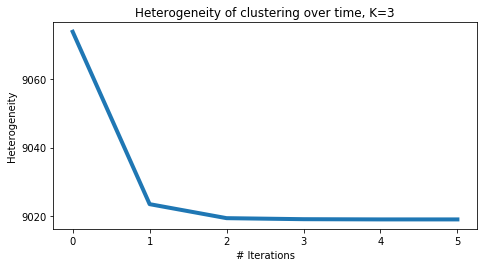

In [9]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

In [10]:
## Testing prob with diff intializations. It gets stuck in local minima
k = 10
heterogeneity = {}
import time
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=8867.84048
seed=020000, heterogeneity=8859.18876
seed=040000, heterogeneity=8886.72693
seed=060000, heterogeneity=8866.68587
seed=080000, heterogeneity=8864.51784
seed=100000, heterogeneity=8855.56810
seed=120000, heterogeneity=8863.47489
34.523499965667725


Notice the variation in heterogeneity for different initializations. This indicates that k-means sometimes gets stuck at a bad local minimum.

To avoid this use 
## Kmeans ++

In [11]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()
    
    for i in np.arange(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        # p is the prob and the value with highest distance will get high prob value and inturn will be picked as idx
        idx = np.random.choice(data.shape[0], 1, p=distances/sum(distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean'),axis=1)
    
    return centroids

In [12]:
k = 10
heterogeneity_smart = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=8855.22888
seed=020000, heterogeneity=8870.80804
seed=040000, heterogeneity=8877.13223
seed=060000, heterogeneity=8853.66381
seed=080000, heterogeneity=8872.02830
seed=100000, heterogeneity=8857.09720
seed=120000, heterogeneity=8858.15604
38.04100012779236


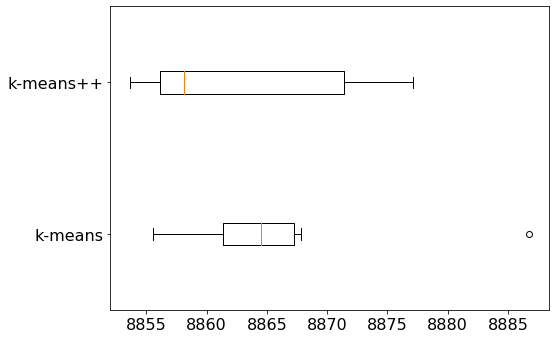

In [13]:
plt.figure(figsize=(8,5))
plt.boxplot([list(heterogeneity.values()), list(heterogeneity_smart.values())], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

A few things to notice from the box plot:
* Random initialization results in a worse clustering than k-means++ on average.
* The best result of k-means++ is better than the best result of random initialization.

KMeans Assignment Summary:
* When working with distance metrics, use cosine similarity or euclidean distance(if normalized).
* TF-IDF penalizes freq words
* Kmeans is solved through co-ord descent algorithm
* Kmeans requires smart initialization as random initialization can cause variation in heterogenity. 
* Stopping criteria: 
    1. If number of changes betw clusters are constant
    2. Max Iterations reached
* Higher number of cluster equalling to N, can cause lowest heterogenity, but thats not satisfactory so check elbow curve
* Kmeans can suffer from getting stuck at local optima, that is evident from variation in heterogenity with random initializations
* The issue can be solved through kmeans++
* High value of K encourages pure clusters but there should be a limit and it depends on particular application.

Few points for good clustering:

What are we looking for in a good clustering of documents?
* Documents in the same cluster should be similar.
* Documents from different clusters should be less similar.

So a bad clustering exhibits either of two symptoms:
* Documents in a cluster have mixed content.
* Documents with similar content are divided up and put into different clusters.

To help visualize the clustering, we do the following:
* Fetch nearest neighbors of each centroid from the set of documents assigned to that cluster. We will consider these documents as being representative of the cluster.
* Print titles and first sentences of those nearest neighbors.
* Print top 5 words that have highest tf-idf weights in each centroid.

